In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [143]:
file_path = '/workspaces/wiggle-face/src/loading_and_feature_extraction/final_data_for_Francis.csv'
data_emotion_6_subjects = pd.read_csv(file_path)

In [144]:
data_emotion_6_subjects = data_emotion_6_subjects.drop(columns=['Unnamed: 0'])
data_emotion_6_subjects['emotion'] = data_emotion_6_subjects['emotion'].replace('sadness ', 'sadness')
data_emotion_6_subjects['emotion'] = data_emotion_6_subjects['emotion'].replace('sleepy', 'neutral')
data_emotion_6_subjects

,video,frame_id,emotion,brain_injury,emotion_category,emotion_category_2
0,r_2024_02_23_833180_242_cam3_vid4,1,neutral,1,neutral,neutral
1,r_2024_02_23_833180_242_cam3_vid4,2,neutral,1,neutral,neutral
2,r_2024_02_23_833180_242_cam3_vid4,3,neutral,1,neutral,neutral
3,r_2024_02_23_833180_242_cam3_vid4,4,neutral,1,neutral,neutral
4,r_2024_02_23_833180_242_cam3_vid4,5,neutral,1,neutral,neutral
...,...,...,...,...,...,...
165595,r_2022_07_01_833180_211_cam3_vid4,7196,neutral,1,neutral,neutral
165596,r_2022_07_01_833180_211_cam3_vid4,7197,neutral,1,neutral,neutral
165597,r_2022_07_01_833180_211_cam3_vid4,7198,neutral,1,neutral,neutral
165598,r_2022_07_01_833180_211_cam3_vid4,7199,neutral,1,neutral,neutral


In [145]:
def categorize_emotion(emotion):
    if emotion in ['interest', 'surprise', 'playful']:
        return 'positive'
    elif emotion in ['neutral', 'sleepy']:
        return 'neutral'
    elif emotion in ['sadness', 'anger']:
        return 'negative'

def categorize_emotion_2(emotion):
    if emotion in ['anger', 'playful']:
        return 'intense'
    elif emotion in ['neutral', 'sleepy']:
        return 'neutral'
    elif emotion in ['interest', 'surprise', 'sadness']:
        return 'mild'
    
# Apply the categorization function to create 'emotion_category'
data_emotion_6_subjects['emotion_category'] = data_emotion_6_subjects['emotion'].apply(categorize_emotion)
data_emotion_6_subjects['emotion_category_2'] = data_emotion_6_subjects['emotion'].apply(categorize_emotion_2)

In [146]:
data_movement_panda_3_filtered = pd.read_csv('/workspaces/wiggle-face/data-ioana/PANDA3/pose_estimates_r_AIM3_2.csv')
data_movement_panda_3_filtered = data_movement_panda_3_filtered.drop(columns=['Unnamed: 0'])

In [147]:
common_videos = data_emotion_6_subjects['video'].unique()
data_movement_panda_3_filtered = data_movement_panda_3_filtered[data_movement_panda_3_filtered['video'].isin(common_videos)]
data_movement_panda_3_filtered.dropna()
data_movement_panda_3_filtered = data_movement_panda_3_filtered[['video_number','video', 'part_idx', 'x', 'y', 'frame_id']]
data_movement_panda_3_filtered = data_movement_panda_3_filtered.reset_index(drop =True)
data_movement_panda_3_filtered

,video_number,video,part_idx,x,y,frame_id
0,18,r_2022_09_08_833180_211_cam3_vid4,1,0.000000,0.000000,0
1,18,r_2022_09_08_833180_211_cam3_vid4,2,-83.334960,-27.348178,0
2,18,r_2022_09_08_833180_211_cam3_vid4,3,-184.365468,3.344254,0
3,18,r_2022_09_08_833180_211_cam3_vid4,4,-234.096883,-37.037673,0
4,18,r_2022_09_08_833180_211_cam3_vid4,5,83.334960,27.348178,0
...,...,...,...,...,...,...
1767371,155,r_2023_07_19_833180_229_cam3_vid4,9,52.355236,322.212719,7468
1767372,155,r_2023_07_19_833180_229_cam3_vid4,10,125.236359,389.894743,7468
1767373,155,r_2023_07_19_833180_229_cam3_vid4,11,133.312361,189.289093,7468
1767374,155,r_2023_07_19_833180_229_cam3_vid4,12,251.053411,199.814122,7468


In [148]:
def euclidean_distance(df):
    df = df.sort_values(by='frame_id')
    df['x_diff'] = df['x'].diff()
    df['y_diff'] = df['y'].diff()
    df['distance'] = np.sqrt(df['x_diff']**2 + df['y_diff']**2)
    return df

def normalize_distances(df):
    df['distance'] = df['distance'] / df['trunk_length']
    return df

def calculate_trunk_length_for_frame(df, frame_id):
    try:
        right_hip_y = df.loc[(df['part_idx'] == 8) & (df['frame_id'] == frame_id), 'y'].values[0]
        left_hip_y = df.loc[(df['part_idx'] == 11) & (df['frame_id'] == frame_id), 'y'].values[0]
        right_shoulder_y = df.loc[(df['part_idx'] == 2) & (df['frame_id'] == frame_id), 'y'].values[0]
        left_shoulder_y = df.loc[(df['part_idx'] == 5) & (df['frame_id'] == frame_id), 'y'].values[0]
        trunk_length = (abs(right_shoulder_y - right_hip_y) + abs(left_shoulder_y - left_hip_y)) / 2
    except IndexError:
        trunk_length = np.nan  # Set trunk length to NaN if any required part is missing
    return trunk_length

def calculate_trunk_lengths(df):
    unique_videos = df['video'].unique()
    trunk_lengths = []

    for video in unique_videos:
        video_df = df[df['video'] == video]
        unique_frames = video_df['frame_id'].unique()
        
        for frame in unique_frames:
            trunk_length = calculate_trunk_length_for_frame(video_df, frame)
            trunk_lengths.append({
                'video': video,
                'frame_id': frame,
                'trunk_length': trunk_length
            })
    
    return pd.DataFrame(trunk_lengths)

In [149]:
data_movement_panda_3_filtered['frame_id'] = data_movement_panda_3_filtered['frame_id'].astype(int)
data_movement_panda_3_filtered['part_idx'] = data_movement_panda_3_filtered['part_idx'].astype(int)
data_movement_panda_3_filtered = data_movement_panda_3_filtered.groupby(['video', 'part_idx'], group_keys=False).apply(euclidean_distance)
trunk_3_lengths_df = calculate_trunk_lengths(data_movement_panda_3_filtered)
data_movement_panda_3_filtered = data_movement_panda_3_filtered.merge(trunk_3_lengths_df, on=['video', 'frame_id'], how='left')
data_movement_panda_3_filtered = data_movement_panda_3_filtered.dropna().reset_index(drop=True)
data_movement_panda_3_filtered = normalize_distances(data_movement_panda_3_filtered)
data_movement_panda_3_filtered['distance'] = data_movement_panda_3_filtered['distance'] * 100 # just for graphing
df_sum_3 = data_movement_panda_3_filtered.groupby(['video', 'frame_id'], group_keys=False)['distance'].sum().reset_index()
df_sum_3['smoothed_distance'] = df_sum_3.groupby('video')['distance'].rolling(window=3).mean().reset_index(level=0, drop=True)
df_sum_3 = df_sum_3.reset_index(drop = True)
df_sum_3['acceleration'] = abs(df_sum_3.groupby('video')['smoothed_distance'].diff().fillna(0))
df_sum_3 = df_sum_3.dropna().reset_index(drop=True)

In [150]:
df_sum_3

,video,frame_id,distance,smoothed_distance,acceleration
0,r_2022_07_01_833180_211_cam3_vid4,3,2.789870,3.793869,0.000000
1,r_2022_07_01_833180_211_cam3_vid4,4,2.940053,3.461788,0.332080
2,r_2022_07_01_833180_211_cam3_vid4,5,3.350937,3.026953,0.434835
3,r_2022_07_01_833180_211_cam3_vid4,6,3.199744,3.163578,0.136625
4,r_2022_07_01_833180_211_cam3_vid4,7,6.138172,4.229618,1.066040
...,...,...,...,...,...
134531,r_2024_05_08_833180_238_cam3_vid4,7623,5.551324,4.574651,0.247324
134532,r_2024_05_08_833180_238_cam3_vid4,7624,6.234321,5.249834,0.675183
134533,r_2024_05_08_833180_238_cam3_vid4,7625,4.644188,5.476611,0.226777
134534,r_2024_05_08_833180_238_cam3_vid4,7626,5.645167,5.507892,0.031281


In [151]:
df_merged = pd.merge(data_emotion_6_subjects, df_sum_3, on=['video', 'frame_id'], how='inner')
df_merged

,video,frame_id,emotion,brain_injury,emotion_category,emotion_category_2,distance,smoothed_distance,acceleration
0,r_2024_03_08_833180_238_cam3_vid4,3,sadness,1,negative,mild,3.703326,4.580107,0.000000
1,r_2024_03_08_833180_238_cam3_vid4,4,sadness,1,negative,mild,1.821934,3.967343,0.612765
2,r_2024_03_08_833180_238_cam3_vid4,5,sadness,1,negative,mild,7.299275,4.274845,0.307503
3,r_2024_03_08_833180_238_cam3_vid4,6,sadness,1,negative,mild,2.374567,3.831925,0.442920
4,r_2024_03_08_833180_238_cam3_vid4,7,sadness,1,negative,mild,2.183526,3.952456,0.120531
...,...,...,...,...,...,...,...,...,...
128260,r_2022_07_01_833180_211_cam3_vid4,7196,neutral,1,neutral,neutral,2.708327,4.120223,0.104553
128261,r_2022_07_01_833180_211_cam3_vid4,7197,neutral,1,neutral,neutral,3.537272,4.099196,0.021027
128262,r_2022_07_01_833180_211_cam3_vid4,7198,neutral,1,neutral,neutral,9.161365,5.135655,1.036459
128263,r_2022_07_01_833180_211_cam3_vid4,7199,neutral,1,neutral,neutral,3.485675,5.394771,0.259116


# Plotting

In [152]:
print(df_merged.isnull().sum())
df_merged = df_merged.dropna()
print(df_merged.isnull().sum())

video                   0
frame_id                0
emotion               106
brain_injury            0
emotion_category      106
emotion_category_2    106
distance                0
smoothed_distance       0
acceleration            0
dtype: int64
video                 0
frame_id              0
emotion               0
brain_injury          0
emotion_category      0
emotion_category_2    0
distance              0
smoothed_distance     0
acceleration          0
dtype: int64


In [153]:
df = df_merged.copy()
df['emotion'] = df['emotion'].astype(str)
df['emotion_category'] = df['emotion_category'].astype(str)
df['emotion_category_2'] = df['emotion_category_2'].astype(str)

In [154]:
# Create a new column for block ids
df['block_id'] = df['frame_id'] // 30

# Function to calculate the mean displacement
def calculate_mean_displacement(block):
    return block['smoothed_distance'].mean()

# Function to find the dominant emotion and emotion category
def find_dominant_emotion(block):
    dominant_emotion = block['emotion'].mode()[0]
    dominant_emotion_category = block['emotion_category'].mode()[0]
    dominant_emotion_category_2 = block['emotion_category_2'].mode()[0]
    brain_injury= block['brain_injury'].mode()[0]
    return pd.Series([dominant_emotion, dominant_emotion_category, dominant_emotion_category_2, brain_injury], index=['dominant_emotion', 'dominant_emotion_category', 'dominant_emotion_category_2', 'brain_injury'])

# Group by video and block_id, then apply the functions
result_df = df.groupby(['video', 'block_id']).apply(lambda block: pd.Series({
    #'video': block['video'].iloc[0],
    'distance': calculate_mean_displacement(block),
    'brain_injury': find_dominant_emotion(block)['brain_injury'],
    'emotion': find_dominant_emotion(block)['dominant_emotion'],
    'emotion_category': find_dominant_emotion(block)['dominant_emotion_category'],
    'emotion_category_2': find_dominant_emotion(block)['dominant_emotion_category_2']
})).reset_index()

In [155]:
merged_df = result_df
merged_df

,video,block_id,distance,brain_injury,emotion,emotion_category,emotion_category_2
0,r_2022_07_01_833180_211_cam3_vid4,0,3.553465,1,neutral,neutral,neutral
1,r_2022_07_01_833180_211_cam3_vid4,1,4.874619,1,neutral,neutral,neutral
2,r_2022_07_01_833180_211_cam3_vid4,2,5.636211,1,neutral,neutral,neutral
3,r_2022_07_01_833180_211_cam3_vid4,3,4.269455,1,neutral,neutral,neutral
4,r_2022_07_01_833180_211_cam3_vid4,4,4.308262,1,neutral,neutral,neutral
...,...,...,...,...,...,...,...
4331,r_2024_05_08_833180_238_cam3_vid4,236,6.245839,1,neutral,neutral,neutral
4332,r_2024_05_08_833180_238_cam3_vid4,237,5.603014,1,neutral,neutral,neutral
4333,r_2024_05_08_833180_238_cam3_vid4,238,12.829547,1,neutral,neutral,neutral
4334,r_2024_05_08_833180_238_cam3_vid4,239,21.804168,1,neutral,neutral,neutral


In [156]:
unique_video_ids = result_df['video'].nunique()
unique_video_ids

18

In [157]:
# df_merged.loc[df_merged['emotion'] == 'aversion', 'emotion'] = 'neutral'
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder

In [158]:
df = merged_df
df = df.dropna(subset=['emotion'])
#df = df[df['emotion'] != 'nan']
#df = df[df['emotion'] != 'sleepy']

Emotion mapping: {0: 'anger', 1: 'interest', 2: 'neutral', 3: 'playful', 4: 'sadness', 5: 'surprise'}


/tmp/ipykernel_4689/3105118775.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


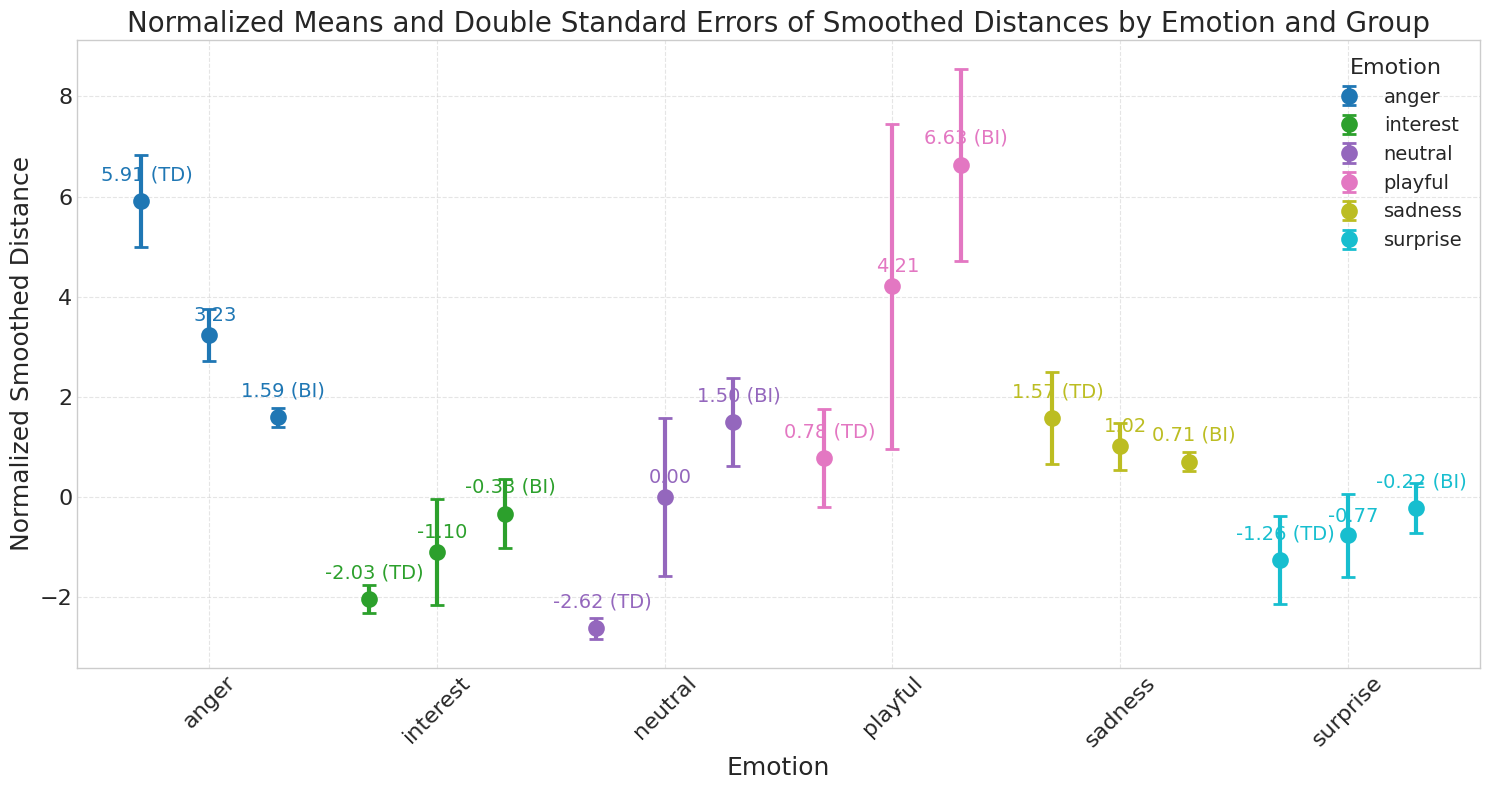

In [159]:
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])


emotion_mapping = {index: emotion for index, emotion in enumerate(label_encoder.classes_)}
print("Emotion mapping:", emotion_mapping)

mean_se_total = df.groupby('emotion_encoded')['distance'].agg(mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x))*2).reset_index()
mean_se_total['emotion'] = label_encoder.inverse_transform(mean_se_total['emotion_encoded'])
mean_se_total['group'] = 'Total'

mean_se_injured = df[df['brain_injury'] == True].groupby('emotion_encoded')['distance'].agg(mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x) *2)).reset_index()
mean_se_injured['emotion'] = label_encoder.inverse_transform(mean_se_injured['emotion_encoded'])
mean_se_injured['group'] = 'Injured'

mean_se_typical = df[df['brain_injury'] == False].groupby('emotion_encoded')['distance'].agg(mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x)) *2).reset_index()
mean_se_typical['emotion'] = label_encoder.inverse_transform(mean_se_typical['emotion_encoded'])
mean_se_typical['group'] = 'Typical'

# Combine all data
mean_se_combined = pd.concat([mean_se_total, mean_se_injured, mean_se_typical])

# Normalize by setting 'neutral' as baseline for each group
neutral_mean = mean_se_total.loc[mean_se_total['emotion'] == 'neutral', 'mean'].values[0]
mean_se_combined['normalized_mean'] = mean_se_combined['mean'] - neutral_mean

# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Define colors for each group
base_colors = plt.cm.tab10(np.linspace(0, 1, len(mean_se_combined['emotion'].unique())))
colors_typical = base_colors
colors_total = [tuple(list(c[:3]) + [1]) for c in base_colors]
colors_injured = [tuple(list(c[:3]) + [1]) for c in base_colors]

# Plot the data
plt.figure(figsize=(15, 8))
for i, emotion in enumerate(mean_se_combined['emotion'].unique()):
    for group in ['Typical', 'Total', 'Injured']:
        subset = mean_se_combined[(mean_se_combined['emotion'] == emotion) & (mean_se_combined['group'] == group)]
        if not subset.empty:
            offset = {'Typical': -0.3, 'Total': 0, 'Injured': 0.3}[group]
            color = {'Typical': colors_typical[i], 'Total': colors_total[i], 'Injured': colors_injured[i]}[group]
            plt.errorbar(i + offset, subset['normalized_mean'], yerr=subset['se'], fmt='o', capsize=5,
                         elinewidth=3, markeredgewidth=2, markersize=10, color=color, label=f"{emotion}" if group == 'Total' else "")
            label = f"{subset['normalized_mean'].values[0]:.2f}"
            if group == 'Typical':
                label += ' (TD)'
            elif group == 'Injured':
                label += ' (BI)'
            plt.annotate(label, (i + offset, subset['normalized_mean'].values[0]), 
                         textcoords="offset points", xytext=(4, 10 if group == 'Total' else 15), ha='center', fontsize=14, color=color)

plt.xlabel('Emotion', fontsize=18)
plt.ylabel('Normalized Smoothed Distance', fontsize=18)
plt.title('Normalized Means and Double Standard Errors of Smoothed Distances by Emotion and Group', fontsize=20)
plt.xticks(range(len(mean_se_combined['emotion'].unique())), mean_se_combined['emotion'].unique(), rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend with only emotions
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Emotion', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()

Emotion Category mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}


/tmp/ipykernel_4689/1724815413.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


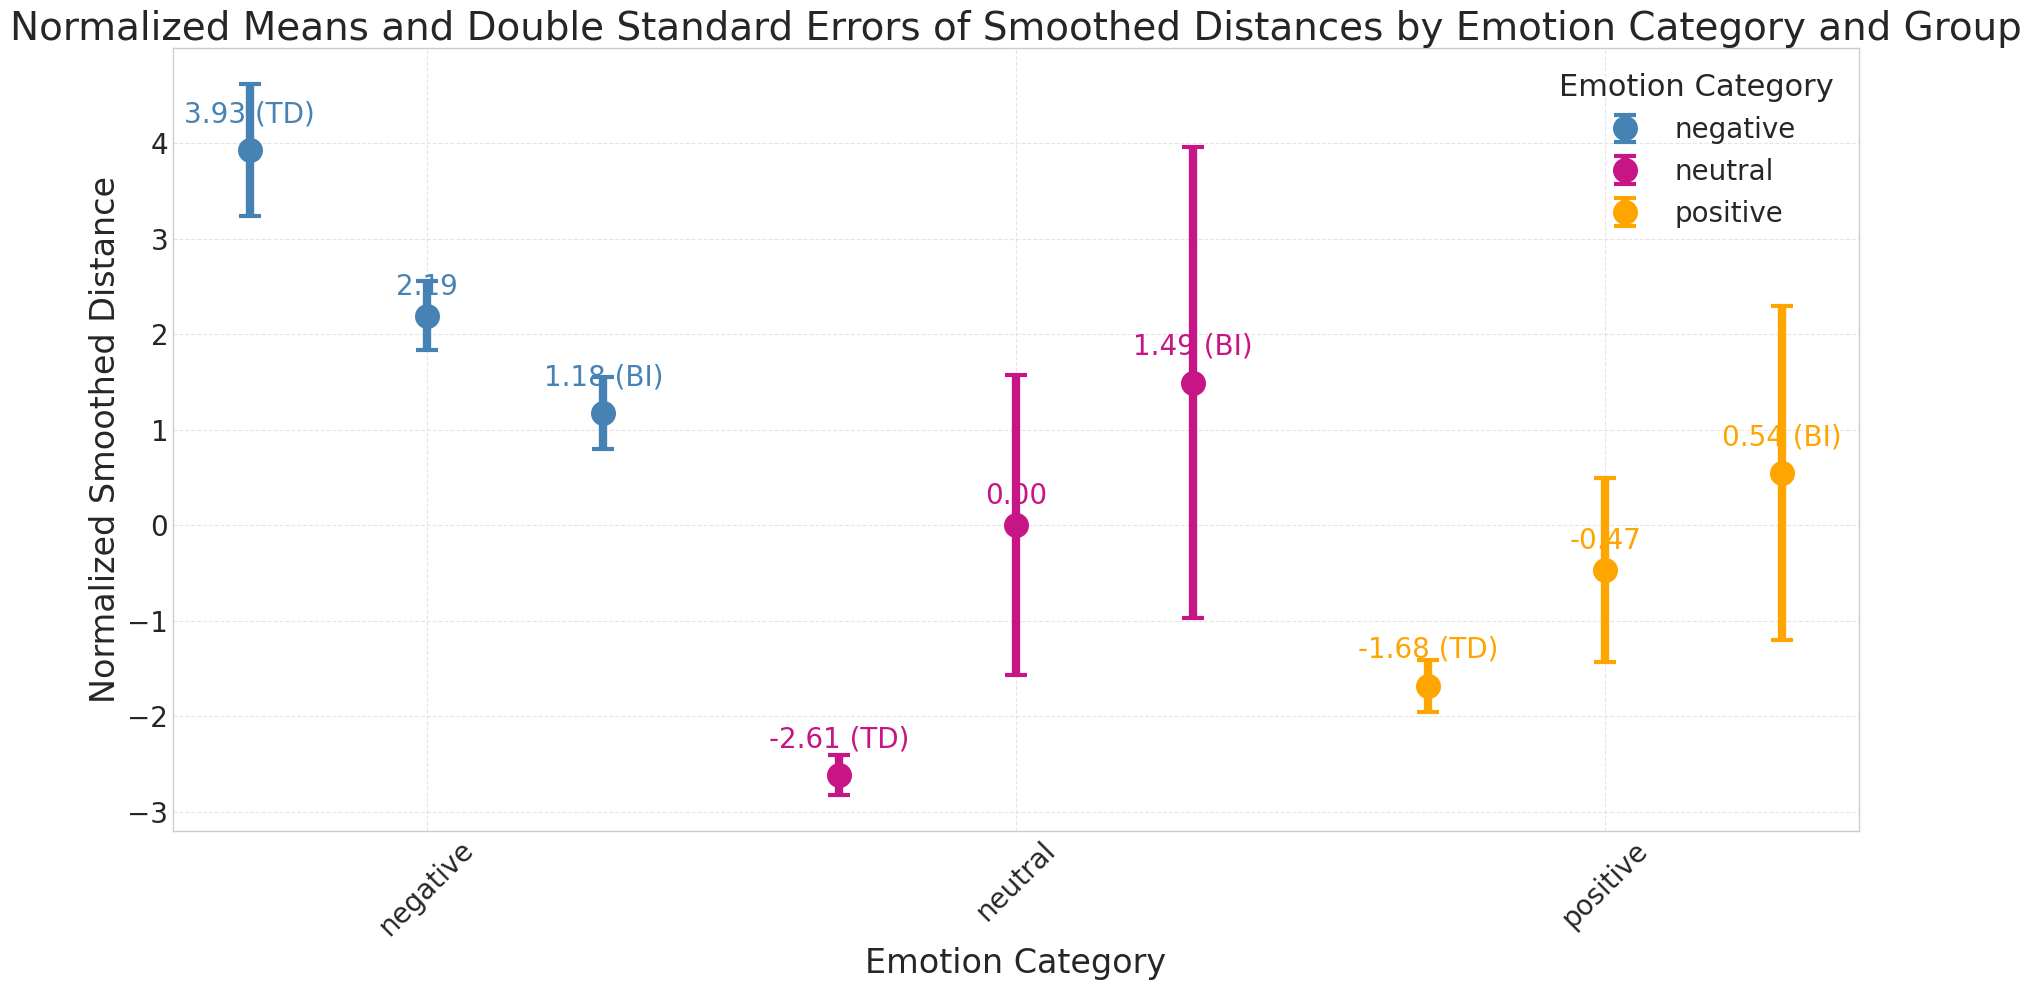

In [160]:
label_encoder = LabelEncoder()
df['emotion_category_encoded'] = label_encoder.fit_transform(df['emotion_category'])

# Create a mapping of encoded labels to emotion categories
emotion_category_mapping = {index: emotion for index, emotion in enumerate(label_encoder.classes_)}
print("Emotion Category mapping:", emotion_category_mapping)

# Compute means and standard errors for total population
mean_se_total = df.groupby('emotion_category_encoded')['distance'].agg(mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x))*2).reset_index()
mean_se_total['emotion_category'] = label_encoder.inverse_transform(mean_se_total['emotion_category_encoded'])
mean_se_total['group'] = 'Total'

# Compute means and standard errors for brain-injured population
mean_se_injured = df[df['brain_injury'] == True].groupby('emotion_category_encoded')['distance'].agg(mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x))*2).reset_index()
mean_se_injured['emotion_category'] = label_encoder.inverse_transform(mean_se_injured['emotion_category_encoded'])
mean_se_injured['group'] = 'Injured'

# Compute means and standard errors for typically developing population
mean_se_typical = df[df['brain_injury'] == False].groupby('emotion_category_encoded')['distance'].agg(mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x))*2).reset_index()
mean_se_typical['emotion_category'] = label_encoder.inverse_transform(mean_se_typical['emotion_category_encoded'])
mean_se_typical['group'] = 'Typical'

# Combine all data
mean_se_combined = pd.concat([mean_se_total, mean_se_injured, mean_se_typical])

# Normalize by setting 'neutral' as baseline for each group
neutral_mean = mean_se_total.loc[mean_se_total['emotion_category'] == 'neutral', 'mean'].values[0]
mean_se_combined['normalized_mean'] = mean_se_combined['mean'] - neutral_mean

# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Define specific colors for each emotion category
color_map = {
    'negative': 'steelblue',
    'neutral': 'mediumvioletred',
    'positive': 'orange',
    # Add more if needed
}

# Create a list of colors based on the emotion category
colors = [color_map[emotion] for emotion in mean_se_combined['emotion_category'].unique()]

# Plot the data
plt.figure(figsize=(18, 10))
for i, emotion_category in enumerate(mean_se_combined['emotion_category'].unique()):
    for group in ['Typical', 'Total', 'Injured']:
        subset = mean_se_combined[(mean_se_combined['emotion_category'] == emotion_category) & (mean_se_combined['group'] == group)]
        if not subset.empty:
            offset = {'Typical': -0.3, 'Total': 0, 'Injured': 0.3}[group]
            color = {'Typical': colors[i], 'Total': colors[i], 'Injured': colors[i]}[group]
            plt.errorbar(i + offset, subset['normalized_mean'], yerr=subset['se'], fmt='o', capsize=8,
                         elinewidth=6, markeredgewidth=3, markersize=15, color=color, label=f"{emotion_category}" if group == 'Total' else "")
            label = f"{subset['normalized_mean'].values[0]:.2f}"
            if group == 'Typical':
                label += ' (TD)'
            elif group == 'Injured':
                label += ' (BI)'
            plt.annotate(label, (i + offset, subset['normalized_mean'].values[0]), 
                         textcoords="offset points", xytext=(0, 15 if group == 'Total' else 20), ha='center', fontsize=20, color=color)

plt.xlabel('Emotion Category', fontsize=24)
plt.ylabel('Normalized Smoothed Distance', fontsize=24)
plt.title('Normalized Means and Double Standard Errors of Smoothed Distances by Emotion Category and Group', fontsize=28)
plt.xticks(range(len(mean_se_combined['emotion_category'].unique())), mean_se_combined['emotion_category'].unique(), rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend with only emotions
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Emotion Category', fontsize=20, title_fontsize=22)

plt.tight_layout()
plt.show()

Emotion Category mapping: {0: 'intense', 1: 'mild', 2: 'neutral'}


/tmp/ipykernel_4689/524928731.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


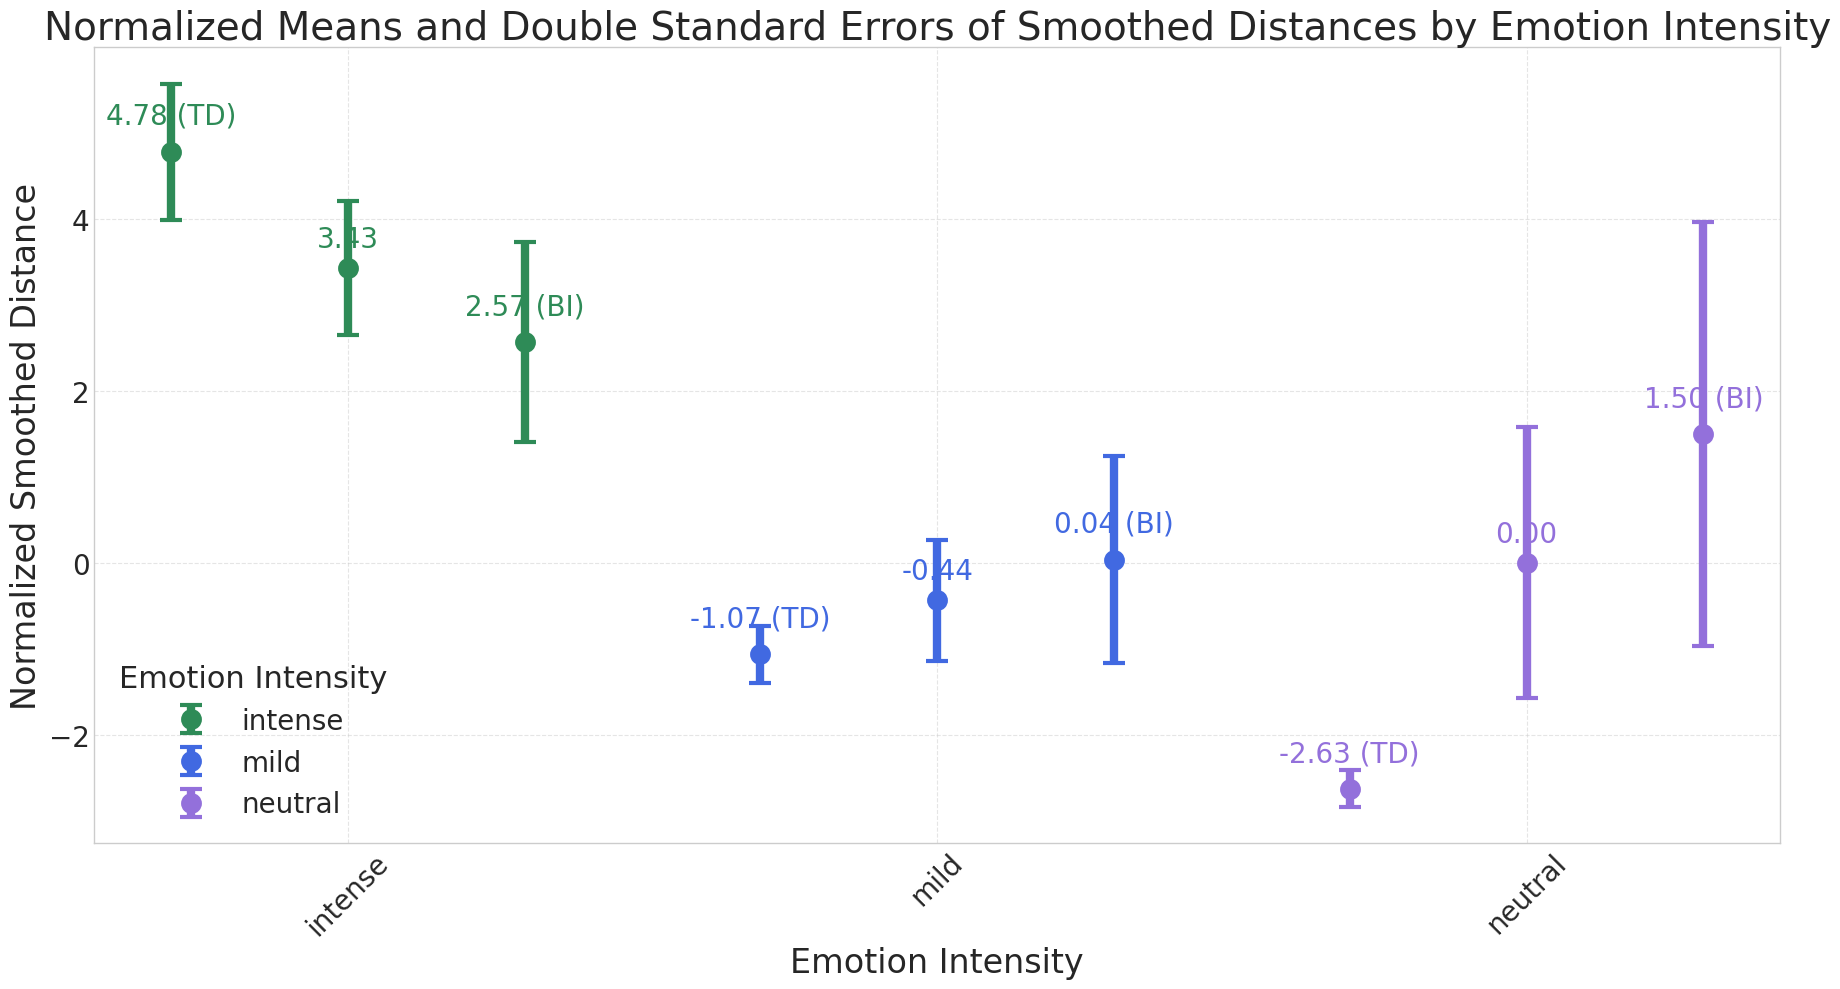

In [161]:
label_encoder = LabelEncoder()
df['emotion_category_encoded'] = label_encoder.fit_transform(df['emotion_category_2'])

# Create a mapping of encoded labels to emotion categories
emotion_category_mapping = {index: emotion for index, emotion in enumerate(label_encoder.classes_)}
print("Emotion Category mapping:", emotion_category_mapping)

# Compute means and standard errors for total population
mean_se_total = df.groupby('emotion_category_encoded')['distance'].agg(mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x))*2).reset_index()
mean_se_total['emotion_category_2'] = label_encoder.inverse_transform(mean_se_total['emotion_category_encoded'])
mean_se_total['group'] = 'Total'

# Compute means and standard errors for brain-injured population
mean_se_injured = df[df['brain_injury'] == True].groupby('emotion_category_encoded')['distance'].agg(mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x))*2).reset_index()
mean_se_injured['emotion_category_2'] = label_encoder.inverse_transform(mean_se_injured['emotion_category_encoded'])
mean_se_injured['group'] = 'Injured'

# Compute means and standard errors for typically developing population
mean_se_typical = df[df['brain_injury'] == False].groupby('emotion_category_encoded')['distance'].agg(mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x))*2).reset_index()
mean_se_typical['emotion_category_2'] = label_encoder.inverse_transform(mean_se_typical['emotion_category_encoded'])
mean_se_typical['group'] = 'Typical'

# Combine all data
mean_se_combined = pd.concat([mean_se_total, mean_se_injured, mean_se_typical])

# Normalize by setting 'neutral' as baseline for each group
neutral_mean = mean_se_total.loc[mean_se_total['emotion_category_2'] == 'neutral', 'mean'].values[0]
mean_se_combined['normalized_mean'] = mean_se_combined['mean'] - neutral_mean

# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Define specific colors for each emotion category
color_map = {
    'intense': 'seagreen',
    'mild': 'royalblue',
    'neutral': 'mediumpurple',
    # Add more if needed
}

# Create a list of colors based on the emotion category
colors = [color_map[emotion] for emotion in mean_se_combined['emotion_category_2'].unique()]

# Plot the data
plt.figure(figsize=(18, 10))
for i, emotion_category in enumerate(mean_se_combined['emotion_category_2'].unique()):
    for group in ['Typical', 'Total', 'Injured']:
        subset = mean_se_combined[(mean_se_combined['emotion_category_2'] == emotion_category) & (mean_se_combined['group'] == group)]
        if not subset.empty:
            offset = {'Typical': -0.3, 'Total': 0, 'Injured': 0.3}[group]
            color = {'Typical': colors[i], 'Total': colors[i], 'Injured': colors[i]}[group]
            plt.errorbar(i + offset, subset['normalized_mean'], yerr=subset['se'], fmt='o', capsize=8,
                         elinewidth=6, markeredgewidth=3, markersize=12, color=color, label=f"{emotion_category}" if group == 'Total' else "")
            label = f"{subset['normalized_mean'].values[0]:.2f}"
            if group == 'Typical':
                label += ' (TD)'
            elif group == 'Injured':
                label += ' (BI)'
            plt.annotate(label, (i + offset, subset['normalized_mean'].values[0]), 
                         textcoords="offset points", xytext=(0, 15 if group == 'Total' else 20), ha='center', fontsize=20, color=color)

plt.xlabel('Emotion Intensity', fontsize=24)
plt.ylabel('Normalized Smoothed Distance', fontsize=24)
plt.title('Normalized Means and Double Standard Errors of Smoothed Distances by Emotion Intensity', fontsize=28)
plt.xticks(range(len(mean_se_combined['emotion_category_2'].unique())), mean_se_combined['emotion_category_2'].unique(), rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend with only emotions
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Emotion Intensity', fontsize=20, title_fontsize=22)

plt.tight_layout()
plt.show()

# New Plots

Emotion mapping: {0: 'anger', 1: 'interest', 2: 'neutral', 3: 'playful', 4: 'sadness', 5: 'surprise'}


/tmp/ipykernel_4689/1111623096.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


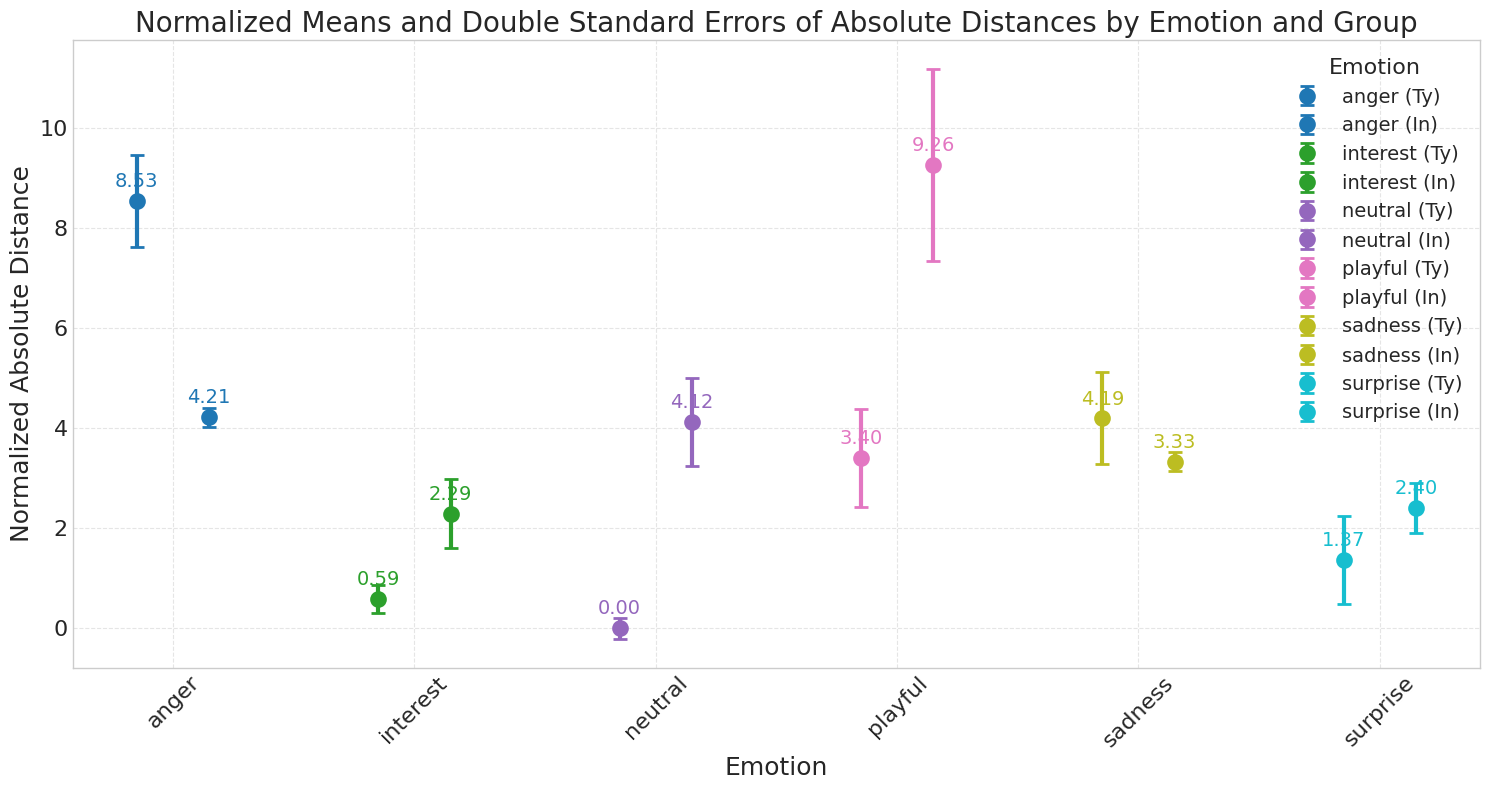

In [165]:
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# Map encoded values back to emotions
emotion_mapping = {index: emotion for index, emotion in enumerate(label_encoder.classes_)}
print("Emotion mapping:", emotion_mapping)

# Convert distances to absolute values
df['abs_distance'] = df['distance'].abs()

# Calculate means and standard errors for 'Typical' and 'Injured' groups
mean_se_injured = df[df['brain_injury'] == True].groupby('emotion_encoded')['abs_distance'].agg(
    mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x) * 2)).reset_index()
mean_se_injured['emotion'] = label_encoder.inverse_transform(mean_se_injured['emotion_encoded'])
mean_se_injured['group'] = 'Injured'

mean_se_typical = df[df['brain_injury'] == False].groupby('emotion_encoded')['abs_distance'].agg(
    mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x)) * 2).reset_index()
mean_se_typical['emotion'] = label_encoder.inverse_transform(mean_se_typical['emotion_encoded'])
mean_se_typical['group'] = 'Typical'

# Combine 'Typical' and 'Injured' data
mean_se_combined = pd.concat([mean_se_injured, mean_se_typical])

# Normalize by setting 'neutral' in 'Typical' group as baseline
neutral_mean_typical = mean_se_typical.loc[mean_se_typical['emotion'] == 'neutral', 'mean'].values[0]
mean_se_combined['normalized_mean'] = mean_se_combined['mean'] - neutral_mean_typical

# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Define colors for each group
base_colors = plt.cm.tab10(np.linspace(0, 1, len(mean_se_combined['emotion'].unique())))
colors_typical = base_colors
colors_injured = [tuple(list(c[:3]) + [1]) for c in base_colors]

# Plot the data
plt.figure(figsize=(15, 8))
for i, emotion in enumerate(mean_se_combined['emotion'].unique()):
    for group in ['Typical', 'Injured']:
        subset = mean_se_combined[(mean_se_combined['emotion'] == emotion) & (mean_se_combined['group'] == group)]
        if not subset.empty:
            offset = {'Typical': -0.15, 'Injured': 0.15}[group]
            color = {'Typical': colors_typical[i], 'Injured': colors_injured[i]}[group]
            plt.errorbar(i + offset, subset['normalized_mean'], yerr=subset['se'], fmt='o', capsize=5,
                         elinewidth=3, markeredgewidth=2, markersize=10, color=color, label=f"{emotion} ({group[:2]})")
            plt.annotate(f"{subset['normalized_mean'].values[0]:.2f}", (i + offset, subset['normalized_mean'].values[0]), 
                         textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, color=color)

plt.xlabel('Emotion', fontsize=18)
plt.ylabel('Normalized Absolute Distance', fontsize=18)
plt.title('Normalized Means and Double Standard Errors of Absolute Distances by Emotion and Group', fontsize=20)
plt.xticks(range(len(mean_se_combined['emotion'].unique())), mean_se_combined['emotion'].unique(), rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend with group annotations
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Emotion', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()

/tmp/ipykernel_4689/2608277016.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


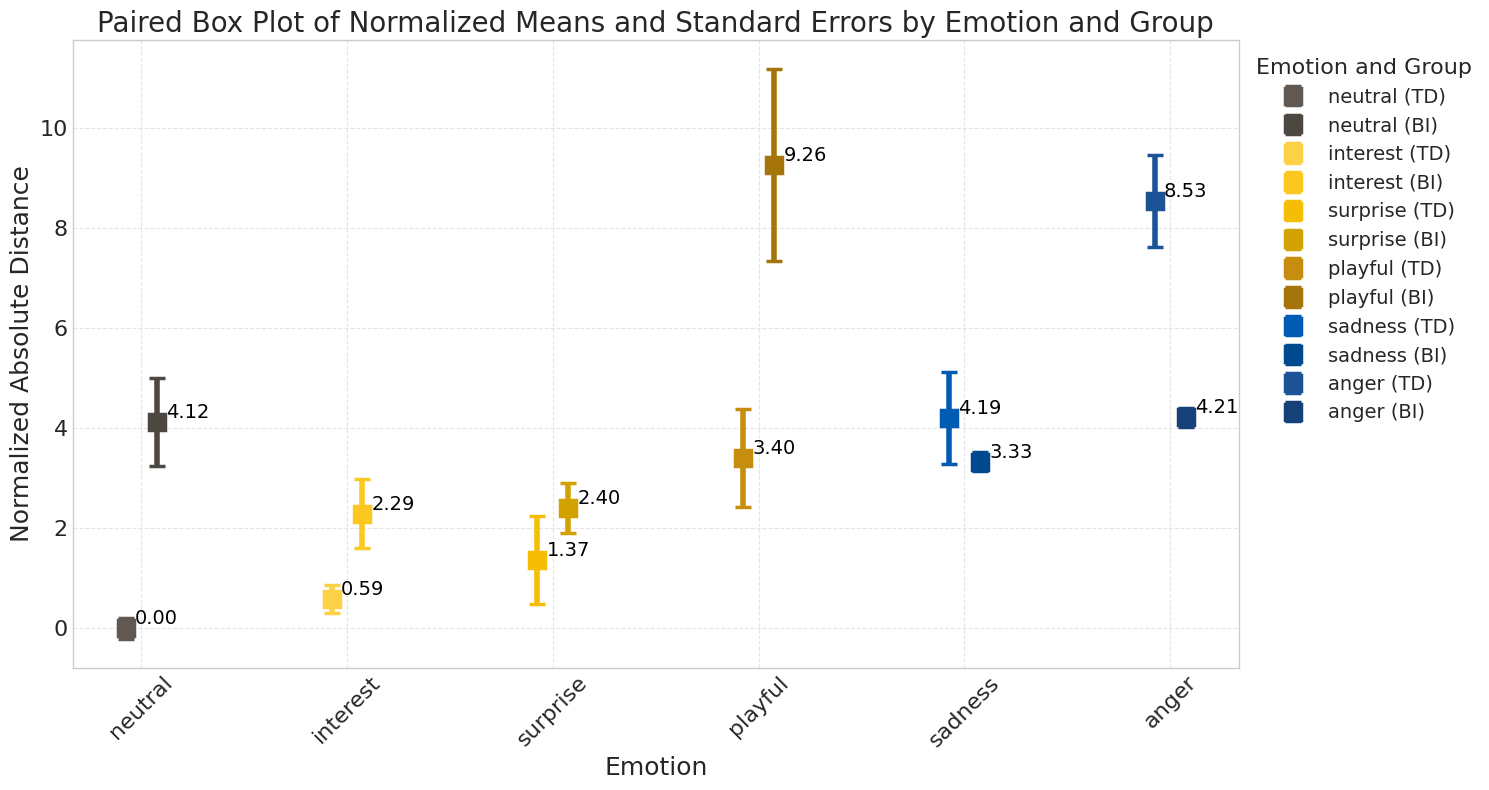

In [186]:
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# Map encoded values back to emotions and manually order them
ordered_emotions = ['neutral', 'interest', 'surprise', 'playful', 'sadness', 'anger']
df['emotion'] = pd.Categorical(df['emotion'], categories=ordered_emotions, ordered=True)
df.sort_values('emotion', inplace=True)  # Sort based on the custom order

# Convert distances to absolute values
df['abs_distance'] = df['distance'].abs()

# Recalculate emotion_encoded to reflect the new order
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# Calculate means and standard errors for 'TD' (TD) and 'BI' (BI) groups
mean_se_injured = df[df['brain_injury'] == True].groupby('emotion_encoded')['abs_distance'].agg(
    mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x) * 2)).reset_index()
mean_se_injured['emotion'] = label_encoder.inverse_transform(mean_se_injured['emotion_encoded'])
mean_se_injured['group'] = 'BI'

mean_se_typical = df[df['brain_injury'] == False].groupby('emotion_encoded')['abs_distance'].agg(
    mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x)) * 2).reset_index()
mean_se_typical['emotion'] = label_encoder.inverse_transform(mean_se_typical['emotion_encoded'])
mean_se_typical['group'] = 'TD'

# Combine 'TD' and 'BI' data
mean_se_combined = pd.concat([mean_se_injured, mean_se_typical])

# Normalize by setting 'neutral' in 'TD' group as baseline
neutral_mean_typical = mean_se_typical.loc[mean_se_typical['emotion'] == 'neutral', 'mean'].values[0]
mean_se_combined['normalized_mean'] = mean_se_combined['mean'] - neutral_mean_typical

# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Define specific color shades for each emotion category with TD being lighter and BI being darker
color_map_td = {
    'neutral': '#605851',  # Light Grey
    'interest': '#fcd145',  # Light Orange
    'surprise': '#f5bd03',  # Light Gold
    'playful': '#c68d0f',  # Light Yellow
    'sadness': '#005cb2',  # Light Blue
    'anger': '#1c5296'  # Medium Blue
}

color_map_bi = {
    'neutral': '#4d4741',  # Dark Grey
    'interest': '#fbc822',  # Dark Orange
    'surprise': '#d2a203',  # Gold
    'playful': '#a5750c',  # Yellow
    'sadness': '#00498e',  # Blue
    'anger': '#164178'  # Dark Blue
}

# Plot the data using error bars and symbolic boxes
fig, ax = plt.subplots(figsize=(15, 8))
x_labels = []
x_ticks = []

for i, emotion in enumerate(ordered_emotions):
    for group in ['TD', 'BI']:
        subset = mean_se_combined[(mean_se_combined['emotion'] == emotion) & (mean_se_combined['group'] == group)]
        if not subset.empty:
            offset = {'TD': i * 2 - 0.15, 'BI': i * 2 + 0.15}[group]
            color = color_map_td[emotion] if group == 'TD' else color_map_bi[emotion]
            ax.errorbar(offset, subset['normalized_mean'], yerr=subset['se'], fmt='s', capsize=6,
                        elinewidth=4, markeredgewidth=2.5, markersize=12, color=color, label=f"{emotion} ({group})")
            # Adjusted to show normalized mean
            ax.text(offset + 0.3, subset['normalized_mean'], f"{subset['normalized_mean'].values[0]:.2f}",
                    horizontalalignment='center', verticalalignment='bottom', fontsize=14, color='black')

            if group == 'TD':
                x_labels.append(emotion)
                x_ticks.append(i * 2)

ax.set_xlabel('Emotion', fontsize=18)
ax.set_ylabel('Normalized Absolute Distance', fontsize=18)
ax.set_title('Paired Box Plot of Normalized Means and Standard Errors by Emotion and Group', fontsize=20)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True, linestyle='--', alpha=0.5)

# Adjust legend positioning to not overlap the data
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
ax.legend(unique_handles, unique_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Emotion and Group', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()

/tmp/ipykernel_4689/2840313156.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


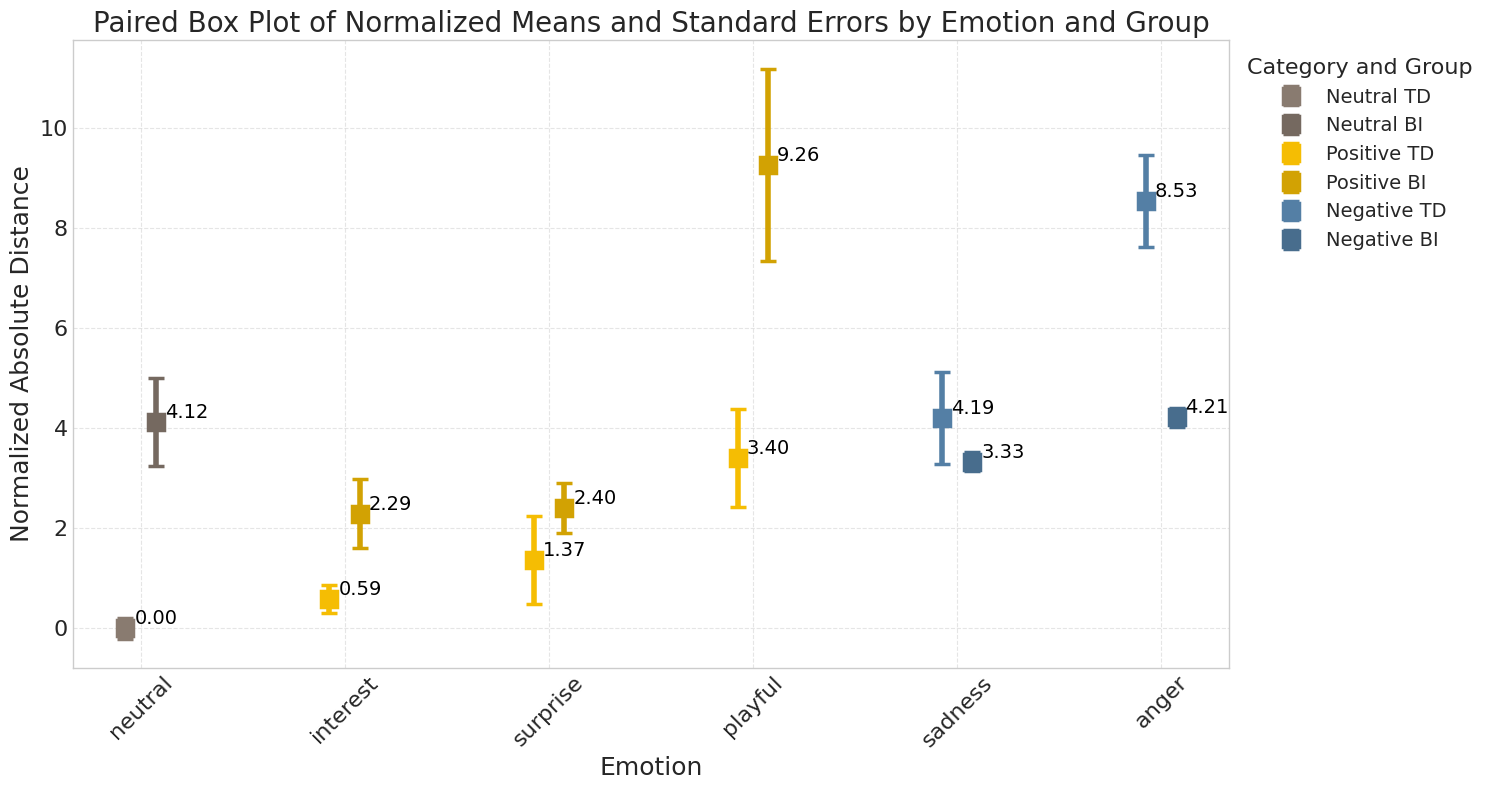

In [204]:
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# Map encoded values back to emotions and manually order them
ordered_emotions = ['neutral', 'interest', 'surprise', 'playful', 'sadness', 'anger']
df['emotion'] = pd.Categorical(df['emotion'], categories=ordered_emotions, ordered=True)
df.sort_values('emotion', inplace=True)  # Sort based on the custom order

# Convert distances to absolute values
df['abs_distance'] = df['distance'].abs()

# Recalculate emotion_encoded to reflect the new order
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# Calculate means and standard errors for 'TD' (TD) and 'BI' (BI) groups
mean_se_injured = df[df['brain_injury'] == True].groupby('emotion_encoded')['abs_distance'].agg(
    mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x) * 2)).reset_index()
mean_se_injured['emotion'] = label_encoder.inverse_transform(mean_se_injured['emotion_encoded'])
mean_se_injured['group'] = 'BI'

mean_se_typical = df[df['brain_injury'] == False].groupby('emotion_encoded')['abs_distance'].agg(
    mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x)) * 2).reset_index()
mean_se_typical['emotion'] = label_encoder.inverse_transform(mean_se_typical['emotion_encoded'])
mean_se_typical['group'] = 'TD'

# Combine 'TD' and 'BI' data
mean_se_combined = pd.concat([mean_se_injured, mean_se_typical])

# Normalize by setting 'neutral' in 'TD' group as baseline
neutral_mean_typical = mean_se_typical.loc[mean_se_typical['emotion'] == 'neutral', 'mean'].values[0]
mean_se_combined['normalized_mean'] = mean_se_combined['mean'] - neutral_mean_typical

# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Define specific color shades for Neutral, Positive, and Negative categories
color_map = {
    'neutral': ('#897b70', '#756960'),  # Light Grey, Dark Grey
    'positive': ('#f5bd03', '#d2a203'),  # Light Yellow, Dark Yellow
    'negative': ('#547fa5', '#486d8d')   # Light Blue, Dark Blue
}

# Assign colors to emotions based on their categories
emotion_color_map = {
    'neutral': color_map['neutral'],
    'interest': color_map['positive'],
    'surprise': color_map['positive'],
    'playful': color_map['positive'],
    'sadness': color_map['negative'],
    'anger': color_map['negative']
}

# Plot the data using error bars and symbolic boxes
fig, ax = plt.subplots(figsize=(15, 8))
x_labels = []
x_ticks = []

for i, emotion in enumerate(ordered_emotions):
    for group in ['TD', 'BI']:
        subset = mean_se_combined[(mean_se_combined['emotion'] == emotion) & (mean_se_combined['group'] == group)]
        if not subset.empty:
            offset = {'TD': i * 2 - 0.15, 'BI': i * 2 + 0.15}[group]
            category = 'neutral' if emotion == 'neutral' else ('positive' if emotion in ['interest', 'surprise', 'playful'] else 'negative')
            color = color_map[category][0] if group == 'TD' else color_map[category][1]
            ax.errorbar(offset, subset['normalized_mean'], yerr=subset['se'], fmt='s', capsize=6,
                        elinewidth=4, markeredgewidth=2.5, markersize=12, color=color, label=f"{category.capitalize()} {group}")
            ax.text(offset + 0.3, subset['normalized_mean'], f"{subset['normalized_mean'].values[0]:.2f}",
                    horizontalalignment='center', verticalalignment='bottom', fontsize=14, color='black')

            if group == 'TD':
                x_labels.append(emotion)
                x_ticks.append(i * 2)

ax.set_xlabel('Emotion', fontsize=18)
ax.set_ylabel('Normalized Absolute Distance', fontsize=18)
ax.set_title('Paired Box Plot of Normalized Means and Double Standard Errors by Emotion and Group', fontsize=20)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True, linestyle='--', alpha=0.5)

# Handling legend to show each color and label correctly
handles, labels = plt.gca().get_legend_handles_labels()
label_handle_dict = dict(zip(labels, handles))  # Creating a dictionary to avoid duplicates
ax.legend(label_handle_dict.values(), label_handle_dict.keys(), loc='upper left', bbox_to_anchor=(1, 1), title='Category and Group', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()

In [207]:
df

,video,block_id,distance,brain_injury,emotion,emotion_category,emotion_category_2,emotion_encoded,emotion_category_encoded,abs_distance
0,r_2022_07_01_833180_211_cam3_vid4,0,3.553465,1,neutral,neutral,neutral,2,2,3.553465
589,r_2022_09_08_833180_211_cam3_vid4,107,2.866164,1,neutral,neutral,neutral,2,2,2.866164
583,r_2022_09_08_833180_211_cam3_vid4,101,5.656482,1,neutral,neutral,neutral,2,2,5.656482
584,r_2022_09_08_833180_211_cam3_vid4,102,4.577697,1,neutral,neutral,neutral,2,2,4.577697
585,r_2022_09_08_833180_211_cam3_vid4,103,2.899998,1,neutral,neutral,neutral,2,2,2.899998
...,...,...,...,...,...,...,...,...,...,...
2176,r_2023_05_03_833180_227_cam3_vid4,8,6.891456,0,anger,negative,intense,0,0,6.891456
2175,r_2023_05_03_833180_227_cam3_vid4,7,5.706235,0,anger,negative,intense,0,0,5.706235
2174,r_2023_05_03_833180_227_cam3_vid4,6,9.492830,0,anger,negative,intense,0,0,9.492830
2198,r_2023_05_03_833180_227_cam3_vid4,30,10.595561,0,anger,negative,intense,0,0,10.595561


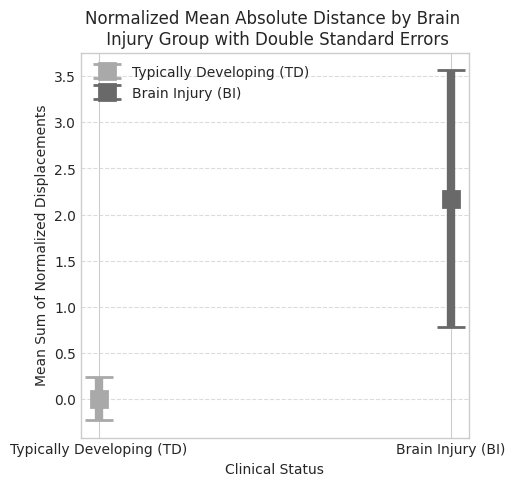

In [249]:
grouped_df = df.groupby('brain_injury')['abs_distance'].agg(['mean', 'sem'])
grouped_df['error'] = grouped_df['sem'] * 2  # double standard error

# Subtract baseline (mean of TD group)
baseline_mean = grouped_df.loc[0, 'mean']
grouped_df['normalized_mean'] = grouped_df['mean'] - baseline_mean

plt.figure(figsize=(5, 5))

# Reduce the spacing between the bars
bar_positions = [1, 3]

# Plot the mean as squares with different colors
plt.errorbar(bar_positions[0], grouped_df['normalized_mean'][0], yerr=grouped_df['error'][0], fmt='s', capsize=10, 
             ecolor='darkgrey', elinewidth=6, markeredgewidth=2, markersize=12, color='darkgrey', label='Typically Developing (TD)')
plt.errorbar(bar_positions[1], grouped_df['normalized_mean'][1], yerr=grouped_df['error'][1], fmt='s', capsize=10, 
             ecolor='dimgrey', elinewidth=6, markeredgewidth=2, markersize=12, color='dimgrey', label='Brain Injury (BI)')

plt.xticks(bar_positions, ['Typically Developing (TD)', 'Brain Injury (BI)'])
plt.xlabel('Clinical Status')
plt.ylabel('Mean Sum of Normalized Displacements')
plt.title('Normalized Mean Absolute Distance by Brain \n Injury Group with Double Standard Errors')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

/tmp/ipykernel_4689/293569503.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


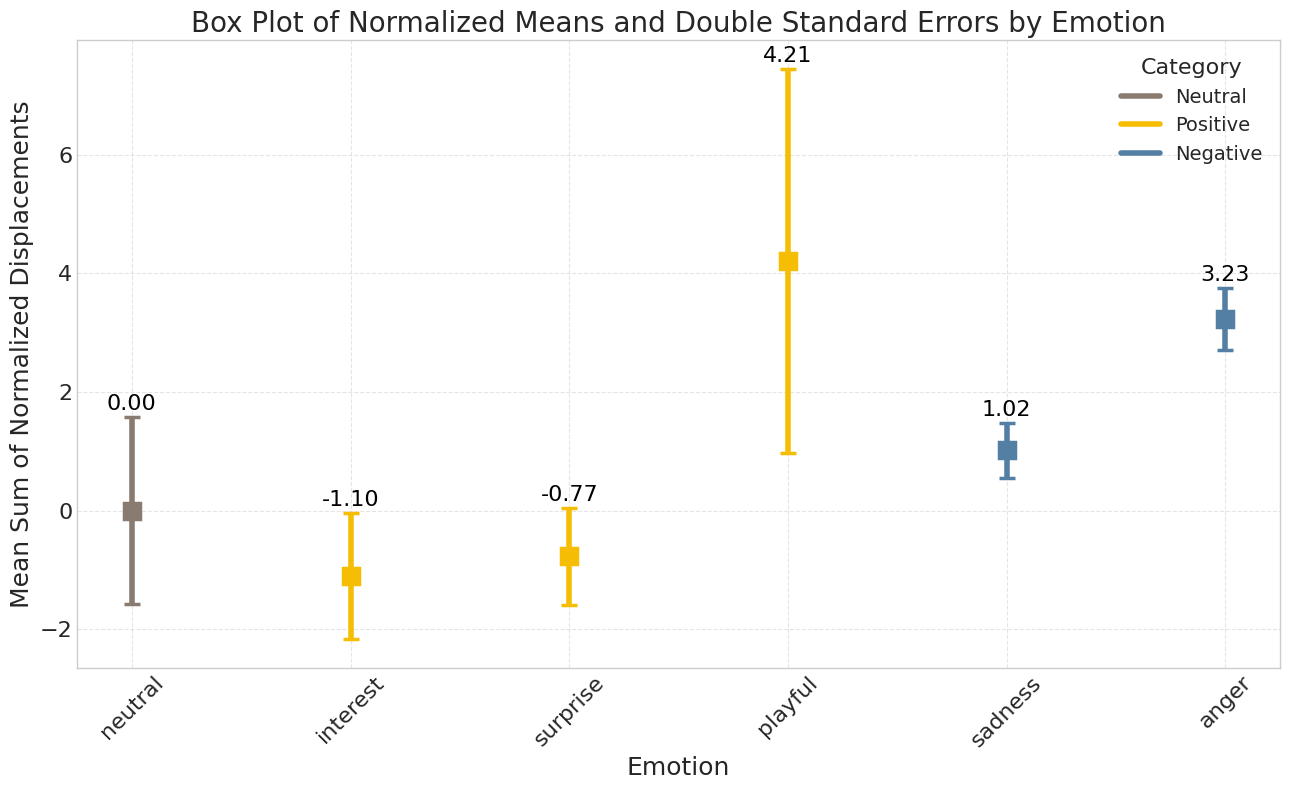

In [246]:
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# Map encoded values back to emotions and manually order them
ordered_emotions = ['neutral', 'interest', 'surprise', 'playful', 'sadness', 'anger']
df['emotion'] = pd.Categorical(df['emotion'], categories=ordered_emotions, ordered=True)
df.sort_values('emotion', inplace=True)  # Sort based on the custom order

# Convert distances to absolute values
df['abs_distance'] = df['distance'].abs()

# Recalculate emotion_encoded to reflect the new order
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# Calculate overall means and standard errors
mean_se_overall = df.groupby('emotion_encoded')['abs_distance'].agg(
    mean='mean', se=lambda x: np.std(x) / np.sqrt(len(x)) * 2).reset_index()
mean_se_overall['emotion'] = label_encoder.inverse_transform(mean_se_overall['emotion_encoded'])

# Normalize by setting 'neutral' as baseline
neutral_mean = mean_se_overall.loc[mean_se_overall['emotion'] == 'neutral', 'mean'].values[0]
mean_se_overall['normalized_mean'] = mean_se_overall['mean'] - neutral_mean

# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Define specific color shades for Neutral, Positive, and Negative categories
color_map = {
    'neutral': '#897b70',  # Grey
    'positive': '#f5bd03',  # Yellow
    'negative': '#547fa5'   # Blue
}

# Assign colors to emotions based on their categories
emotion_color_map = {
    'neutral': color_map['neutral'],
    'interest': color_map['positive'],
    'surprise': color_map['positive'],
    'playful': color_map['positive'],
    'sadness': color_map['negative'],
    'anger': color_map['negative']
}

# Category mapping for the legend
category_legend_map = {
    'neutral': 'Neutral',
    'positive': 'Positive',
    'negative': 'Negative'
}

# Plot the data using error bars and symbolic boxes
fig, ax = plt.subplots(figsize=(13, 8))
x_labels = []
x_ticks = []
legend_handles = {}

for i, emotion in enumerate(ordered_emotions):
    subset = mean_se_overall[mean_se_overall['emotion'] == emotion]
    if not subset.empty:
        category = 'neutral' if emotion == 'neutral' else ('positive' if emotion in ['interest', 'surprise', 'playful'] else 'negative')
        color = emotion_color_map[emotion]
        ax.errorbar(i, subset['normalized_mean'], yerr=subset['se'], fmt='s', capsize=6,
                    elinewidth=4, markeredgewidth=2.5, markersize=12, color=color, label=category_legend_map[category])
        ax.text(i, subset['normalized_mean'] + subset['se'] + 0.05, f"{subset['normalized_mean'].values[0]:.2f}", 
                horizontalalignment='center', verticalalignment='bottom', fontsize=16, color='black')

        x_labels.append(emotion)
        x_ticks.append(i)

        # Create legend handles
        if category_legend_map[category] not in legend_handles:
            legend_handles[category_legend_map[category]] = plt.Line2D([0], [0], color=color, lw=4, label=category_legend_map[category])

ax.set_xlabel('Emotion', fontsize=18)
ax.set_ylabel('Mean Sum of Normalized Displacements', fontsize=18)
ax.set_title('Box Plot of Normalized Means and Double Standard Errors by Emotion', fontsize=20)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True, linestyle='--', alpha=0.5)

# Add custom legend within the plot area
ax.legend(handles=legend_handles.values(), loc='upper right', title='Category', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()